In [1]:
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
% matplotlib inline
import csv
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import random

In [2]:
def get_error_rate(pred, Y):
    d = zip(pred,Y)
    err = 0.0
    for (a,b) in d:
        if not(a==b or (a==-1 and b==0)):
            err += 1.0
    
    return (err / float(len(Y)))

In [3]:
def adaboost(X_train, Y_train, X_test, Y_test, rounds, classifier, margin = 0):
    # Initialize Weights as 1/m for each data point in the distribution
    weights = np.ones(len(X_train)) / len(X_train)
    full_preds_train = [0]*len(X_train)
    full_preds_test = [0]*len(X_test)
    
    for k in range(rounds):
        classifier.fit(X_train, Y_train, sample_weight = weights)
        
        predictions_train = classifier.predict(X_train)
        predictions_test = classifier.predict(X_test)
        testing = zip(predictions_train, Y_train)
        wrong_preds_train = []
        # 1/-1 values
        neg_pos = []
        
        for (p,y) in testing:
            if p!=y:
                wrong_preds_train.append(1)
                neg_pos.append(-1)
            else:
                wrong_preds_train.append(0)
                neg_pos.append(1)
                
        err_t = np.dot(weights,wrong_preds_train)/sum(weights)
        alpha_t = 0.5*np.log((1-err_t)/err_t)+0.5*np.log((1.0-margin)/(margin+1.0))
        Z_t = 2*math.sqrt(err_t*(1-err_t)/((1.0-margin)*(1.0+margin)))
        
        for i in range(len(weights)):
            weights[i] *= np.exp(-1*alpha_t*neg_pos[i])/Z_t
        
        p_train = [x*alpha_t for x in predictions_train]
        p_test = [x*alpha_t for x in predictions_test]
        
        
        for i in range(len(full_preds_train)):
            full_preds_train[i] += p_train[i]
        for i in range(len(full_preds_test)):
            full_preds_test[i] += p_test[i]
    signs_preds_train = (np.sign(full_preds_train)).tolist()
    signs_pred_test = (np.sign(full_preds_test)).tolist()        
        
    return (get_error_rate(signs_preds_train,Y_train),get_error_rate(signs_pred_test, Y_test))        
    

In [4]:
def plot_error_rate(x, er_train, er_test, baseline_test):
    plt.plot(x,er_test, linestyle='-', marker='o', color='red', label = "Test")
    plt.plot(x,er_train, linestyle='-', marker='o', color='darkblue', label = "Train")
    plt.axhline(y=baseline_test, linewidth=1, color = 'red', ls = 'dashed', label = 'baseline')
    plt.xlabel('Number of iterations', fontsize = 12)
    plt.ylabel('Accuracy (1- error)', fontsize = 12)
    plt.title('Accuracy vs number of iterations', fontsize = 16)    
    plt.legend()
    plt.show()

In [5]:
def cleanup(arr):
    for i in range(len(arr)):
        if arr[i]==0:
            arr[i] = -1  
    return arr

In [6]:
def plot_margin(frac, rho, clr):
    x = [0,0.2,0.4,0.6,0.8,1.0]
    plt.plot(x, frac, linestyle='-', marker='o', c=clr, label = format(rho,'.2f'))
    plt.xlabel('Theta', fontsize = 12)
    plt.ylabel('Fraction of training points with margin <= theta', fontsize = 12)
    plt.title('Margins', fontsize = 16)    
    plt.legend(loc = "lower right")
    return plt
    

Fitting Decision Tree..
Getting initial error rate..
Baseline Accuracy:  0.7933333333333333 0.795
Margin: 0
Starting Adaboost..
Round:  100
Starting Adaboost..
Round:  200
Starting Adaboost..
Round:  500
Starting Adaboost..
Round:  1000


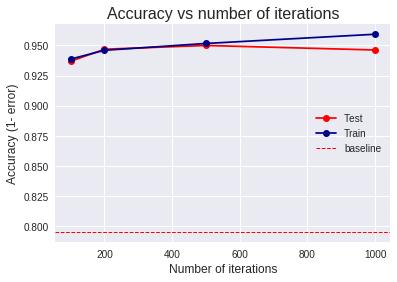

Margin: 0.00390625
Starting Adaboost..
Round:  100
Starting Adaboost..
Round:  200
Starting Adaboost..
Round:  500
Starting Adaboost..
Round:  1000


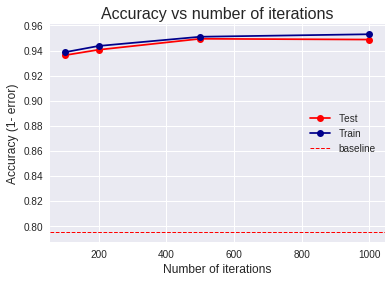

Best Accuracy Obtained:  0.95  with # of rounds:  1000  & margin:  0


In [7]:
if __name__ == '__main__':
    
    # Read data
    df = pd.read_csv('spambase.csv',header=None,delimiter=',')
    output = df[57]
    df = df.drop(57,1)
    
    X_scaled = preprocessing.scale(df)
    X_train = X_scaled[0:3000]
    Y_train = output[0:3000]
    Y_train = Y_train.as_matrix()
    Y_train = cleanup(Y_train)
    
    X_test= X_scaled[3001:]
    Y_test = output[3001:]
    Y_test = Y_test.as_matrix()
    Y_test = cleanup(Y_test)
    
    # Fit a simple decision tree first
    print ("Fitting Decision Tree..")
    clf = DecisionTreeClassifier(max_depth = 1, random_state = 1)
    clf.fit(X_train,Y_train)
    
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    
    print ("Getting initial error rate..")

    baseline_test = 1.0-get_error_rate(pred_test, Y_test)
    
    print ("Baseline Accuracy: ",1.0-get_error_rate(pred_train, Y_train), baseline_test)
    x = [100,200,500,1000]
    m = [0, 2**-8]
    best_rho = -12
    best_rounds = 0
    best_acc = -999
    for rho in m:
        err_train= []
        err_test = []
        mgn = []
        print ("Margin: "+str(rho)) 
        for rounds in x:
            print ("Starting Adaboost..")
            print ("Round: ",rounds)
            (e_train,e_test) = adaboost(X_train, Y_train, X_test, Y_test, rounds, clf, rho)
            err_train.append(1.0-e_train)
            err_test.append(1.0-e_test)
            if (1.0-e_test)>best_acc:
                best_acc = (1.0-e_test)
                best_rho = rho
                best_rounds = rounds
                
        # Compare error rate vs number of iterations
        plot_error_rate(x, err_train, err_test, baseline_test)

    plt.show()
    print ("Best Accuracy Obtained: ",best_acc," with # of rounds: ",rounds," & margin: ",best_rho)